# Modelo de deep learning baseado na memória de curto prazo (LSTM)

## Bibliotecas

In [155]:

# Estamos usando a versão 3.10.11 do python

# pip install pandas tensorflow matplotlib scikit-learn pandas_datareader

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score, mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pathlib import Path
import os
pd.options.mode.chained_assignment = None

## Tratmento das bases

In [156]:
# Diretório onde o script está localizado
base_diretório = Path(os.getcwd())
base_diretório = base_diretório.parent
caminho = base_diretório / 'Bases' / 'Bitcoin Historical Data.csv'

# Ler arquivo da base
acao = pd.read_csv(caminho)

# Formatar data
acao['Date'] = pd.to_datetime(acao['Date'], format='%m/%d/%Y')

# Filtrar a data em que vamos puxar os dados
# acao = acao[acao['Date'].dt.year >= 2023]

# Converter as colunas referentes a dinheiro para float
colunas_dinheiro = ['Price', 'Open', 'High', 'Low']
for coluna in colunas_dinheiro:
    if acao[coluna].dtype == 'object':  
        acao[coluna] = pd.to_numeric(acao[coluna].str.replace(',', ''))

# Converter a coluna 'Change %' para float
if acao['Change %'].dtype == 'object':  
    acao['Change %'] = pd.to_numeric(acao['Change %'].str.replace('%', ''))

def converter_vol_para_numero(valor):
    if isinstance(valor, str):  # Verifica se o valor é uma string
        if 'K' in valor:
            return float(valor.replace('K', '').replace(',', '')) * 1000
        elif 'M' in valor:
            return float(valor.replace('M', '').replace(',', '')) * 1000000
        elif 'B' in valor:
            return float(valor.replace('B', '').replace(',', '')) * 1000000000
        else:
            return float(valor.replace(',', ''))
    else:
        return valor  # Retorna o valor diretamente se já for numérico

# Aplicar a função na coluna 'Vol.'
acao['Vol.'] = acao['Vol.'].apply(converter_vol_para_numero)

# Ordenar data das bases
acao = acao.sort_values(by='Date', ascending=True)

acao = acao.rename(columns={'Vol.': 'Volume', 'Change %': 'Change'})

acao

,Date,Price,Open,High,Low,Volume,Change
0,2017-01-01,995.4,963.4,1001.6,956.1,41150.0,3.33
1,2017-01-02,1017.0,995.4,1031.7,990.2,64950.0,2.17
2,2017-01-03,1033.3,1017.0,1035.5,1006.5,54790.0,1.60
3,2017-01-04,1135.4,1033.3,1148.5,1022.3,156270.0,9.88
4,2017-01-05,989.3,1135.4,1150.6,874.5,240010.0,-12.86
...,...,...,...,...,...,...,...
2795,2024-08-27,59450.9,62832.2,63201.4,58187.3,108530.0,-5.40
2796,2024-08-28,59016.0,59425.6,60198.4,57912.1,109470.0,-0.73
2797,2024-08-29,59373.5,59027.3,61150.6,58807.1,87190.0,0.61
2798,2024-08-30,59119.7,59371.7,59817.6,57874.7,87310.0,-0.43


## Aplicando modelo de ML

In [157]:
#nao pode ser ajustados

cotacao = acao['Price'].to_numpy().reshape(-1, 1)

cotacao

array([[  995.4],
       [ 1017. ],
       [ 1033.3],
       ...,
       [59373.5],
       [59119.7],
       [58978.6]])

In [158]:
tamanho_dados_treinamento = int(len(cotacao) * 0.8)

tamanho_dados_treinamento

2240

In [159]:
#escalar os dados entre 0 e 1, para deixar mais fácil o processamento
#dados em escala pré definidas são mais fáceis de lidar. 

escalador = MinMaxScaler(feature_range=(0, 1))

dados_entre_0_e_1_treinamento = escalador.fit_transform(cotacao[0: tamanho_dados_treinamento, :])

dados_entre_0_e_1_teste = escalador.transform(cotacao[tamanho_dados_treinamento: , :])

dados_entre_0_e_1 = list(dados_entre_0_e_1_treinamento.reshape(
    len(dados_entre_0_e_1_treinamento))) + list(dados_entre_0_e_1_teste.reshape(len(dados_entre_0_e_1_teste)))
                                                

dados_entre_0_e_1 = np.array(dados_entre_0_e_1).reshape(len(dados_entre_0_e_1), 1)

dados_entre_0_e_1

array([[0.00314642],
       [0.00347005],
       [0.00371428],
       ...,
       [0.87782298],
       [0.8740203 ],
       [0.87190621]])

In [160]:
dados_para_treinamento = dados_entre_0_e_1[0: tamanho_dados_treinamento, :]

#dados que serão usados para gerar o resultado
treinamento_x = []
#cotação que aconteceu de fato
treinamento_y = []


for i in range(60, len(dados_para_treinamento)):

    #60 ultimos dias
    treinamento_x.append(dados_para_treinamento[i - 60: i, 0])
    #cotacao
    treinamento_y.append(dados_para_treinamento[i, 0])

    if i <= 61:

        print(treinamento_x)
        print(treinamento_y)



[array([0.00314642, 0.00347005, 0.00371428, 0.00524403, 0.00305502,
       0.00151028, 0.00155074, 0.00173053, 0.00171405, 0.00178297,
       0.        , 0.00037008, 0.00059033, 0.00051242, 0.00053639,
       0.00062779, 0.00171255, 0.00129752, 0.00164513, 0.00161067,
       0.00201371, 0.00199873, 0.00203918, 0.00162415, 0.00163314,
       0.00195078, 0.00198674, 0.00199423, 0.0019343 , 0.00202719,
       0.00269843, 0.00295164, 0.00327527, 0.00341012, 0.0036918 ,
       0.00345657, 0.00358542, 0.0039585 , 0.0040469 , 0.0029007 ,
       0.00317938, 0.0033397 , 0.0031629 , 0.00314642, 0.0033397 ,
       0.0033382 , 0.0036933 , 0.0039555 , 0.00399895, 0.00394801,
       0.00437802, 0.00499831, 0.00502079, 0.00579091, 0.00585983,
       0.0054493 , 0.00578642, 0.00604412, 0.00605162, 0.00655205])]
[0.007043488032363187]
[array([0.00314642, 0.00347005, 0.00371428, 0.00524403, 0.00305502,
       0.00151028, 0.00155074, 0.00173053, 0.00171405, 0.00178297,
       0.        , 0.00037008, 0.00

In [161]:
#transformando as listas em arrays e dando reshape 3d 

treinamento_x, treinamento_y = np.array(treinamento_x), np.array(treinamento_y)

print(treinamento_x)

treinamento_x = treinamento_x.reshape(treinamento_x.shape[0], treinamento_x.shape[1], 1)

print(treinamento_x)

[[0.00314642 0.00347005 0.00371428 ... 0.00604412 0.00605162 0.00655205]
 [0.00347005 0.00371428 0.00524403 ... 0.00605162 0.00655205 0.00704349]
 [0.00371428 0.00524403 0.00305502 ... 0.00655205 0.00704349 0.00746001]
 ...
 [0.23906357 0.23457167 0.24148631 ... 0.31445031 0.32083155 0.35273626]
 [0.23457167 0.24148631 0.24042252 ... 0.32083155 0.35273626 0.3409252 ]
 [0.24148631 0.24042252 0.24025471 ... 0.35273626 0.3409252  0.35641608]]
[[[0.00314642]
  [0.00347005]
  [0.00371428]
  ...
  [0.00604412]
  [0.00605162]
  [0.00655205]]

 [[0.00347005]
  [0.00371428]
  [0.00524403]
  ...
  [0.00605162]
  [0.00655205]
  [0.00704349]]

 [[0.00371428]
  [0.00524403]
  [0.00305502]
  ...
  [0.00655205]
  [0.00704349]
  [0.00746001]]

 ...

 [[0.23906357]
  [0.23457167]
  [0.24148631]
  ...
  [0.31445031]
  [0.32083155]
  [0.35273626]]

 [[0.23457167]
  [0.24148631]
  [0.24042252]
  ...
  [0.32083155]
  [0.35273626]
  [0.3409252 ]]

 [[0.24148631]
  [0.24042252]
  [0.24025471]
  ...
  [0.3527

In [162]:
#construindo o modelo

modelo = Sequential()

#vamos criar um modelo com 50 neurônios
#return sequences = True pois vamos usar outro LSTM depois.
#definir o shape, que no caso são 60 informações para gerar uma.
#Adicionar mais neurônios com o dense, 25 e 1
#Não se apegue a isso agora, é apenas um arquitetura de deep learning.

# Primeira camada LSTM com dropout
modelo.add(LSTM(100, return_sequences=True, input_shape=(treinamento_x.shape[1], 1)))
modelo.add(Dropout(0.2))

# Segunda camada LSTM
modelo.add(LSTM(50, return_sequences=False))
# modelo.add(Dropout(0.2))

# Camada totalmente conectada com 25 neurônios
modelo.add(Dense(25))

# Camada final de saída com 1 neurônio
modelo.add(Dense(1))

treinamento_x.shape[1]

c:\Users\yupopic\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60

In [163]:
#copilando o modelo

# a função de loss é a forma de medir o erro do modelo, que nesse caso
#é o classico erro médio quadrático da que é usado em regressão linear
#otimizador e medida de erro

modelo.compile(optimizer="adam", loss="mean_squared_error") 

In [164]:
#agora com o modelo copilado e os dados, podemos treinar o modelo
#batch size é depois de quantas em quantas amostras o modelo irá otimizar os parâmetros.
#epochs é quantas vezes o algoritmo irá rodar os dados treinamento, aprendendo. 

modelo.fit(treinamento_x, treinamento_y, batch_size=1, epochs=1)

2180/2180 ━━━━━━━━━━━━━━━━━━━━ 74s 32ms/step - loss: 0.0045


In [165]:
# Vriar dados de teste

dados_teste = dados_entre_0_e_1[tamanho_dados_treinamento - 60:, :]

teste_x = []
teste_y = cotacao[tamanho_dados_treinamento: , :] 

for i in range(60, len(dados_teste)):
    teste_x.append(dados_teste[i - 60: i, 0])
    

In [166]:
# Reshape
teste_x = np.array(teste_x)
teste_x = teste_x.reshape(teste_x.shape[0], teste_x.shape[1], 1)

In [167]:
#pegando predições do modelo

predicoes = modelo.predict(teste_x)

#tirando a escala dos dados

predicoes = escalador.inverse_transform(predicoes)

predicoes

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step


array([[24889.963],
       [25295.46 ],
       [25645.414],
       [25839.363],
       [25872.688],
       [25770.453],
       [25482.943],
       [25138.674],
       [24885.18 ],
       [24708.375],
       [24539.32 ],
       [24490.752],
       [24483.795],
       [24311.682],
       [24080.87 ],
       [23869.447],
       [23699.404],
       [23543.318],
       [23337.83 ],
       [22910.832],
       [22401.201],
       [21980.639],
       [21932.924],
       [22453.262],
       [23297.162],
       [24110.566],
       [24902.863],
       [25967.377],
       [26916.951],
       [27833.516],
       [28536.02 ],
       [29076.625],
       [29288.434],
       [29473.957],
       [29458.83 ],
       [29342.793],
       [29276.51 ],
       [29096.781],
       [28912.16 ],
       [28944.238],
       [29027.332],
       [29205.098],
       [29401.139],
       [29531.523],
       [29538.482],
       [29544.234],
       [29548.846],
       [29528.754],
       [29477.744],
       [29424.809],


In [168]:
# Criando o grafico do modelo
treinamento = acao.iloc[:tamanho_dados_treinamento, :]
df_teste = pd.DataFrame({"Price": acao['Price'].iloc[tamanho_dados_treinamento:],
                        "predicoes": predicoes.reshape(len(predicoes))})


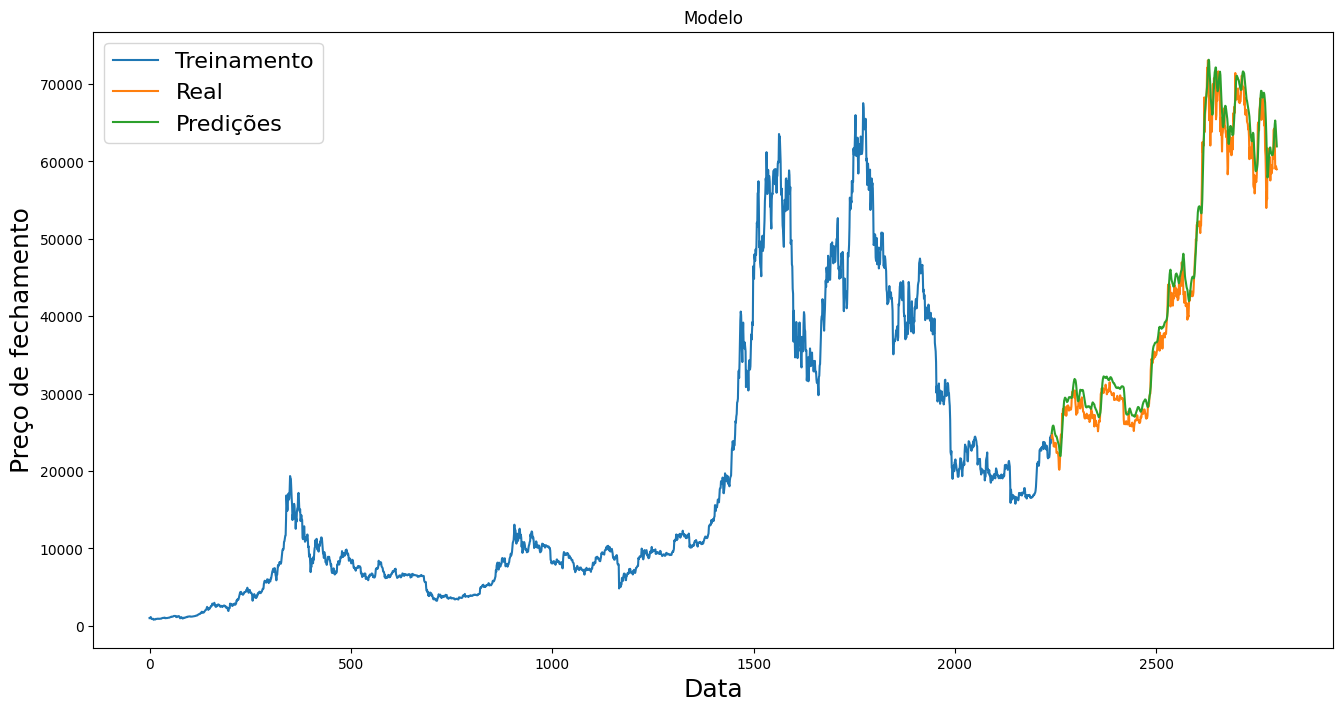

In [169]:
plt.figure(figsize =(16, 8))
plt.title('Modelo')
plt.xlabel('Data', fontsize = 18)
plt.ylabel("Preço de fechamento", fontsize = 18)
plt.plot(treinamento['Price'])
plt.plot(df_teste[['Price', 'predicoes']])
plt.legend(['Treinamento', 'Real', 'Predições'], loc=2, prop={'size': 16})
plt.show()

In [170]:
df_teste.sort_index()

df_teste

,Price,predicoes
2240,24302.9,24889.962891
2241,24839.5,25295.460938
2242,24450.7,25645.414062
2243,24186.6,25839.363281
2244,23936.3,25872.687500
...,...,...
2795,59450.9,65282.625000
2796,59016.0,64746.511719
2797,59373.5,63760.980469
2798,59119.7,62790.074219


# Metricas para calcular nosso modelo de ML

### Mean Absolute Error (MAE) e Mean Absolute Percentage Error (MAPE)

In [171]:
# Calcular o MAE
mae = mean_absolute_error(df_teste['Price'], df_teste['predicoes'])

print(f"Mean Absolute Error (MAE): {mae:.2f}")

Mean Absolute Error (MAE): 1821.13


In [172]:
# Calcular o MAPE
mape = mean_absolute_percentage_error(df_teste['Price'], df_teste['predicoes'])

print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}")

Mean Absolute Percentage Error (MAPE): 0.05


### Root Mean Squared Error (RMSE) e Mean Squared Error (MSE)

In [173]:
# Calcular o RMSE
rmse = mean_squared_error(df_teste['Price'], df_teste['predicoes'], squared=False)

print(f"rmse: {rmse}")

rmse: 2251.0476566528305


c:\Users\yupopic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### R² (Coeficiente de Determinação) 

In [174]:
# Calcular o R²
r2 = r2_score(df_teste['Price'], df_teste['predicoes'])

print(f"R²: {r2}")

R²: 0.9814796141655663


### Directional Accuracy

In [175]:
# Cálculo da variação percentual entre os valores consecutivos
df_teste['variacao_real'] = df_teste['Price'].pct_change()
df_teste['variacao_prevista'] = df_teste['predicoes'].pct_change()

# Remover NaN (primeira linha não terá variação por não ter valor anterior)
df = df_teste.dropna()

# Calcular se a direção do valor previsto foi igual ao real (1 = acertou | 0 = errou)
df['direcao_correta'] = np.where(
    (df['variacao_real'] > 0) & (df['variacao_prevista'] > 0) |
    (df['variacao_real'] < 0) & (df['variacao_prevista'] < 0),
    1, 0
)

# Calcular a métrica de Erro de Direção (Directional Accuracy)
directional_accuracy = df['direcao_correta'].mean()

# Exibir resultados
print(f"Directional Accuracy: {directional_accuracy * 100:.2f}%")

df

Directional Accuracy: 47.23%


,Price,predicoes,variacao_real,variacao_prevista,direcao_correta
2241,24839.5,25295.460938,0.022080,0.016292,1
2242,24450.7,25645.414062,-0.015652,0.013835,0
2243,24186.6,25839.363281,-0.010801,0.007563,0
2244,23936.3,25872.687500,-0.010349,0.001290,0
2245,23191.5,25770.453125,-0.031116,-0.003951,1
...,...,...,...,...,...
2795,59450.9,65282.625000,-0.054026,0.007214,0
2796,59016.0,64746.511719,-0.007315,-0.008212,1
2797,59373.5,63760.980469,0.006058,-0.015221,0
2798,59119.7,62790.074219,-0.004275,-0.015227,1


In [176]:
#criando um código que você passa 60 dias e ele devolve a cotação
#resumindo: vamos descobrir o preço da petrobras de hoje/amanha com esse modelo

data_hoje = datetime.now()

#se quiser escolher um dia, basta fazer assim

#data_hoje = datetime.now() - timedelta(days = 1)

if data_hoje.hour > 18:
    
    final = data_hoje
    inicial = datetime.now() - timedelta(days = 252)
    
else:
    final = data_hoje - timedelta(days = 1)
    inicial = datetime.now() - timedelta(days = 252)
    
ultimos_60_dias = acao['Price'].iloc[-60:].values.reshape(-1, 1)

ultimos_60_dias_escalado = escalador.transform(ultimos_60_dias)

teste_x = []
teste_x.append(ultimos_60_dias_escalado)
teste_x = np.array(teste_x)
teste_x = teste_x.reshape(teste_x.shape[0], teste_x.shape[1], 1)

previsao_de_preco = modelo.predict(teste_x)
previsao_de_preco = escalador.inverse_transform(previsao_de_preco)

print(previsao_de_preco)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
[[61274.977]]
